<a href="https://colab.research.google.com/github/jiyun-kong/Jeju_price_prediction_project/blob/main/Jeju.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset Info.

1. train.csv
- train 데이터 : 2019년 01월 01일부터 2023년 03월 03일까지의 유통된 품목의 가격 - 데이터
  - item: 품목 코드
  - TG : 감귤
  - BC : 브로콜리
  - RD : 무
  - CR : 당근
  - CB : 양배추
  - corporation : 유통 법인 코드
    - 법인 A부터 F 존재
  - location : 지역 코드
    - J : 제주도 제주시
    - S : 제주도 서귀포시
  - supply(kg) : 유통된 물량, kg 단위
  - price(원/kg) : 유통된 품목들의 kg 마다의 가격, 원 단위

2. international_trade.csv
- 관련 품목 수출입 정보

3. test.csv
- test 데이터 : 2023년 03월 04일부터 2023년 03월 31일까지의 데이터

4. sample_submission.csv
- 제출을 위한 양식
- 2023년 03월 04일부터 2023년 03월 31일까지의 price(원/kg)을 예측
- ID는 품목, 유통 법인, 지역 코드로 구성된 식별자
- 해당 ID에 맞춰 price(원/kg) 예측값을 answer 컬럼에 기입해야 함


In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [98]:
from sklearn.metrics import mean_squared_error

def rmse(y_test, y_pred):
  return np.sqrt(mean_squared_error(y_test, y_pred))

In [88]:
train = pd.read_csv("/content/drive/MyDrive/jeju_data/train.csv")
train.shape # 총 59397개 데이터, 7개 컬럼

(59397, 7)

In [89]:
train_df = train.drop(columns='ID')
train_df.rename(columns={'price(원/kg)':'price(won/kg)'}, inplace=True)
train_df.head()

,timestamp,item,corporation,location,supply(kg),price(won/kg)
0,2019-01-01,TG,A,J,0.0,0.0
1,2019-01-02,TG,A,J,0.0,0.0
2,2019-01-03,TG,A,J,60601.0,1728.0
3,2019-01-04,TG,A,J,25000.0,1408.0
4,2019-01-05,TG,A,J,32352.0,1250.0


In [90]:
# 날짜 데이터 datetime 형식으로 변환
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
train_df.head()

,timestamp,item,corporation,location,supply(kg),price(won/kg)
0,2019-01-01,TG,A,J,0.0,0.0
1,2019-01-02,TG,A,J,0.0,0.0
2,2019-01-03,TG,A,J,60601.0,1728.0
3,2019-01-04,TG,A,J,25000.0,1408.0
4,2019-01-05,TG,A,J,32352.0,1250.0


In [91]:
train_df['timestamp'].unique

<bound method Series.unique of 0       2019-01-01
1       2019-01-02
2       2019-01-03
3       2019-01-04
4       2019-01-05
           ...    
59392   2023-02-27
59393   2023-02-28
59394   2023-03-01
59395   2023-03-02
59396   2023-03-03
Name: timestamp, Length: 59397, dtype: datetime64[ns]>

In [92]:
train_timestamp = train_df.set_index('timestamp')
train_timestamp.head()

,item,corporation,location,supply(kg),price(won/kg)
timestamp,,,,,
2019-01-01,TG,A,J,0.0,0.0
2019-01-02,TG,A,J,0.0,0.0
2019-01-03,TG,A,J,60601.0,1728.0
2019-01-04,TG,A,J,25000.0,1408.0
2019-01-05,TG,A,J,32352.0,1250.0


In [93]:
# 날짜에 따른 가격 변동 시각화
items = train_df['item'].unique()
print(items)
train_df['item'].value_counts()

['TG' 'CR' 'CB' 'RD' 'BC']


TG    15230
BC    13707
RD    12184
CR    10661
CB     7615
Name: item, dtype: int64

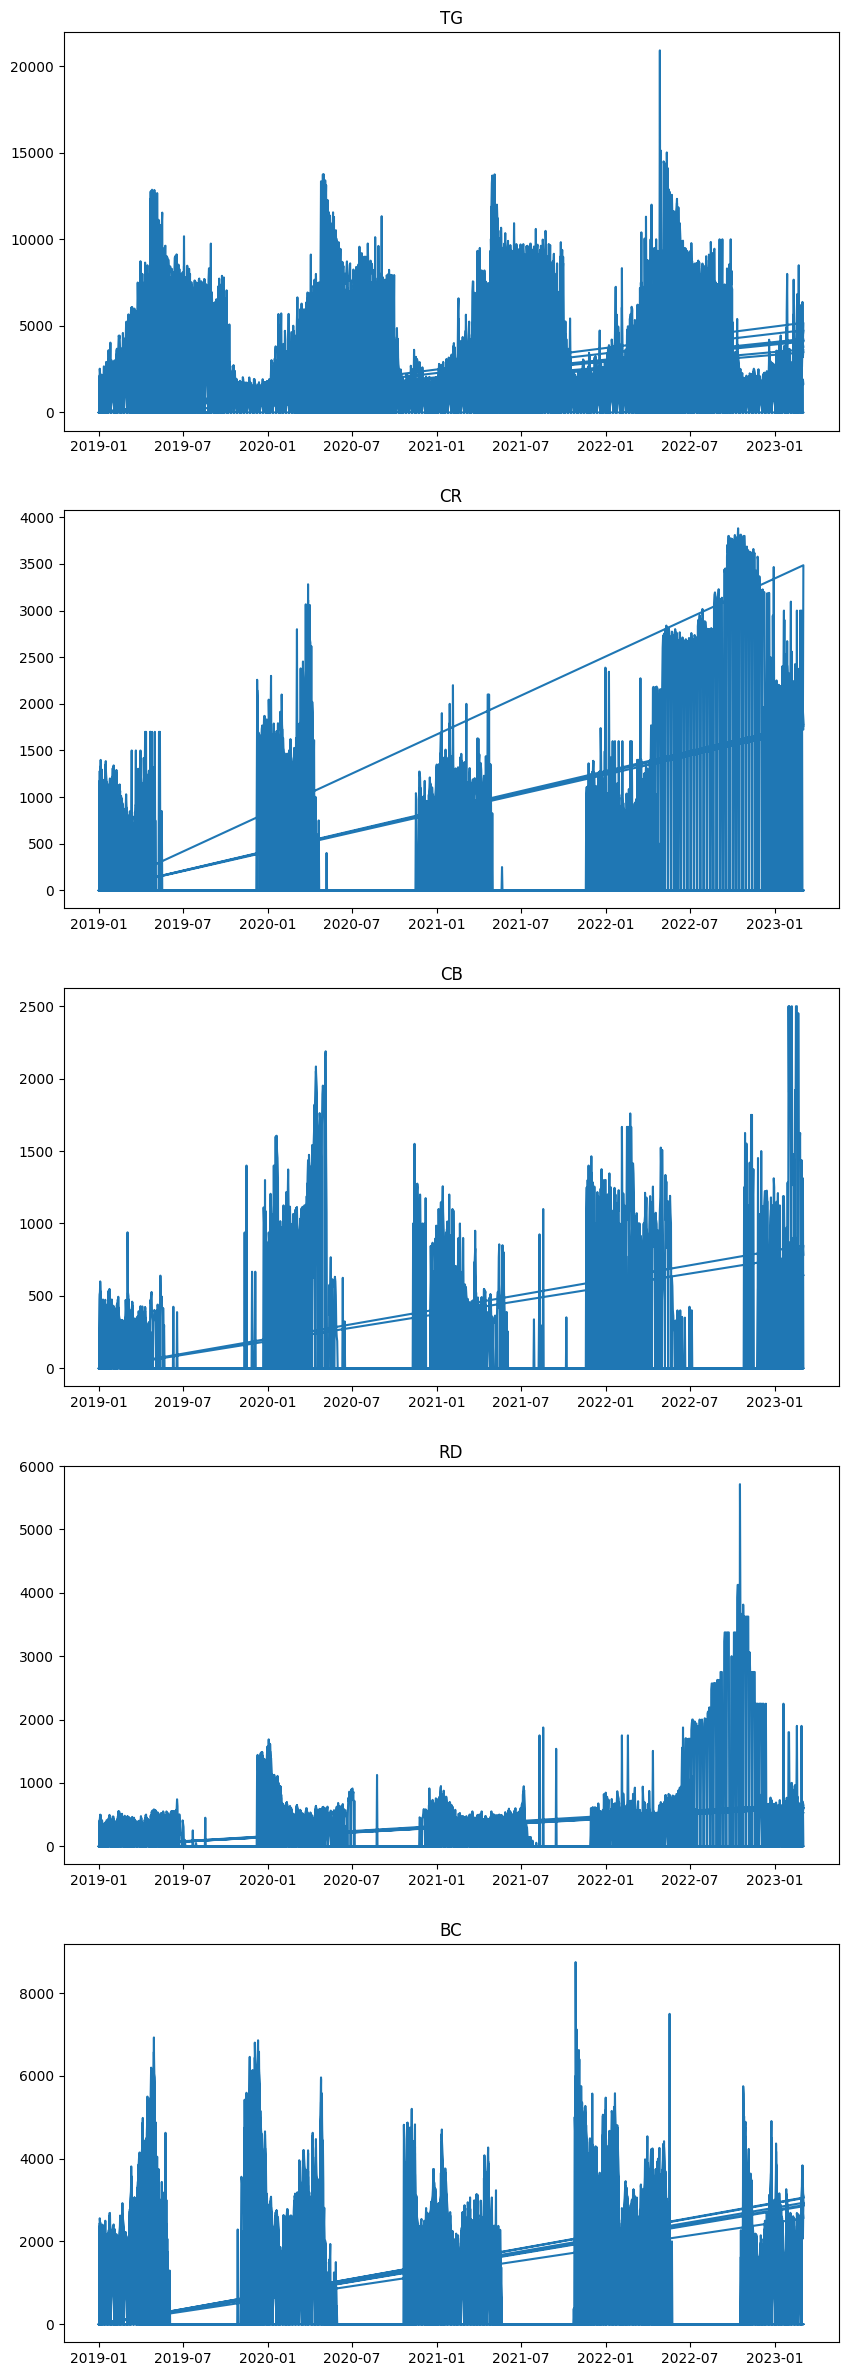

In [94]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 30))
for i, item in enumerate(items):
  axes[i].plot(train_timestamp[train_timestamp['item'] == item]['price(won/kg)'])
  axes[i].set_title(item)
plt.show()

In [95]:
# timestamp를 년도-달 별로 구분하여 price(won/kg) 파악
train_df['year_month'] = train_df['timestamp'].dt.to_period('M')
train_df.head()

,timestamp,item,corporation,location,supply(kg),price(won/kg),year_month
0,2019-01-01,TG,A,J,0.0,0.0,2019-01
1,2019-01-02,TG,A,J,0.0,0.0,2019-01
2,2019-01-03,TG,A,J,60601.0,1728.0,2019-01
3,2019-01-04,TG,A,J,25000.0,1408.0,2019-01
4,2019-01-05,TG,A,J,32352.0,1250.0,2019-01


In [96]:
item_year_month = train_df.groupby(['item', 'year_month'])
agg_dict = {'price(won/kg)' : ['mean', 'max']}
item_year_month_price = item_year_month.agg(agg_dict).reset_index()
item_year_month_price

item year_month price(won/kg)        
                             mean     max
0     BC    2019-01   1278.086022  2689.0
1     BC    2019-02   1152.563492  2925.0
2     BC    2019-03   1772.620072  4149.0
3     BC    2019-04   2288.400000  6929.0
4     BC    2019-05    658.265233  5965.0
..   ...        ...           ...     ...
250   TG    2022-11   1361.850000  2526.0
251   TG    2022-12   1696.103226  4202.0
252   TG    2023-01   1782.693548  8000.0
253   TG    2023-02   2250.250000  8500.0
254   TG    2023-03   3442.633333  6382.0

[255 rows x 4 columns]

In [97]:
item_year_month_price.columns = ['item', 'year_month', 'item_year_month_mean', 'item_year_month_max']
train_df = pd.merge(train_df, item_year_month_price, on=['item', 'year_month'], how='left')
train_df.head()

,timestamp,item,corporation,location,supply(kg),price(won/kg),year_month,item_year_month_mean,item_year_month_max
0,2019-01-01,TG,A,J,0.0,0.0,2019-01,1485.383871,4031.0
1,2019-01-02,TG,A,J,0.0,0.0,2019-01,1485.383871,4031.0
2,2019-01-03,TG,A,J,60601.0,1728.0,2019-01,1485.383871,4031.0
3,2019-01-04,TG,A,J,25000.0,1408.0,2019-01,1485.383871,4031.0
4,2019-01-05,TG,A,J,32352.0,1250.0,2019-01,1485.383871,4031.0


In [35]:
# 공급과 가격의 상관관계 파악 - 상관관계가 없나봄..
sup_price_corr = train_df['supply(kg)'].corr(train_df['price(won/kg)'])
sup_price_corr

-0.0022967366004861545

In [107]:
# RandomForestRegressor
from sklearn.model_selection import train_test_split

y = train_df['price(won/kg)']
X = train_df.drop(['price(won/kg)', 'corporation', 'location'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(47517, 6) (11880, 6) (47517,) (11880,)


In [108]:
# Timestamp를 POSIX time으로 바꾸기 (1970-01-01 이후로의 seconds)
X_train['timestamp'] = (X_train['timestamp'] - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
X_test['timestamp'] = (X_test['timestamp'] - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')

In [130]:
# month_year를 POSIX time으로 바꾸기 (1970-01-01 이후로의 seconds)
X_train['year_month'] = (X_train['year_month'].dt.to_timestamp() - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
X_test['year_month'] = (X_test['year_month'].dt.to_timestamp() - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')

In [111]:
# item OneHotEncoding
X_train = pd.get_dummies(X_train, columns=['item'])
X_test = pd.get_dummies(X_test, columns=['item'])

In [131]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
rmse_ = rmse(y_test, y_pred)
rmse_

531.7302560907284